# SparseEdges : computing sparseness of natural imaghes with retina-like RFs

Let's compute the "edges" produced with symmetrical filters.

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../test

/Users/laurentperrinet/pool/science/BICV/SparseEdges/test


In [3]:
!rm -fr **/retina_sparseness* **/**/retina_sparseness*

In [4]:
import holoviews as hv
%load_ext holoviews.ipython
%output size=150 dpi=120
%opts Image (cmap='gray')
%opts Image.Fourier_domain (cmap='hot')
def fourier_domain(arr):
    return hv.Image(arr, group='Fourier domain',
                 key_dimensions=[r'$f_x$', r'$f_y$'],
                 value_dimensions=[hv.Dimension('Fourier')])
def image_domain(arr):
    return hv.Image(arr,group='Image domain',
                 key_dimensions=[r'$x$', r'$y$'],
                 value_dimensions=[hv.Dimension('Image', range=(-1,1))])

from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import os
import numpy as np
np.set_printoptions(precision=2, suppress=True)
FORMATS = ['pdf', 'eps']

defining framework


In [5]:
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = 'database'
mp.pe.noise = 0.5

print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.62  0.38  0.24  0.15  0.09  0.06  0.03  0.02  0.01  0.01  0.01]


Standard edges are oriented, but one may modify that:

:Layout
   .Fourier_domain.I :Image   [$f_x$,$f_y$]   (Fourier)
   .Image_domain.I   :Image   [$x$,$y$]   (Image)
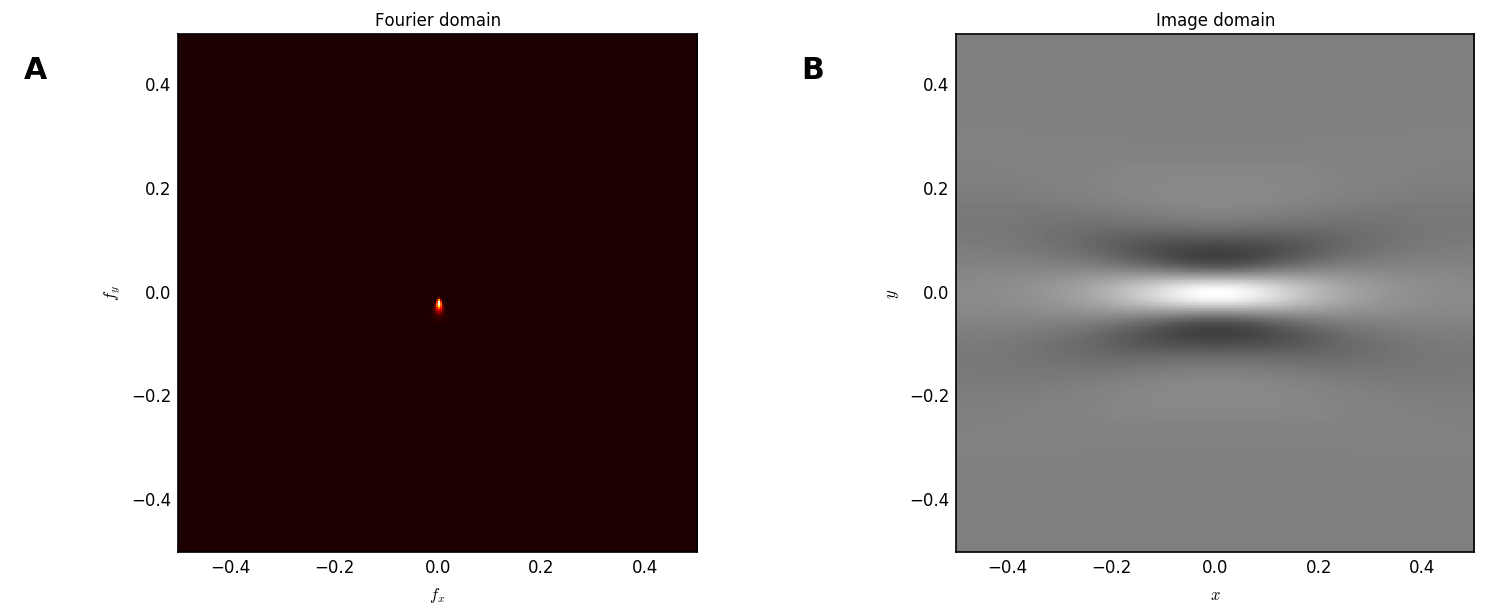

In [6]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': mp.pe.B_theta}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
(fourier_domain(mp.normalize(np.absolute(FT_lg), center=False))
+ image_domain(mp.normalize(mp.invert(FT_lg), center=False)))

:Layout
   .Fourier_domain.I :Image   [$f_x$,$f_y$]   (Fourier)
   .Image_domain.I   :Image   [$x$,$y$]   (Image)
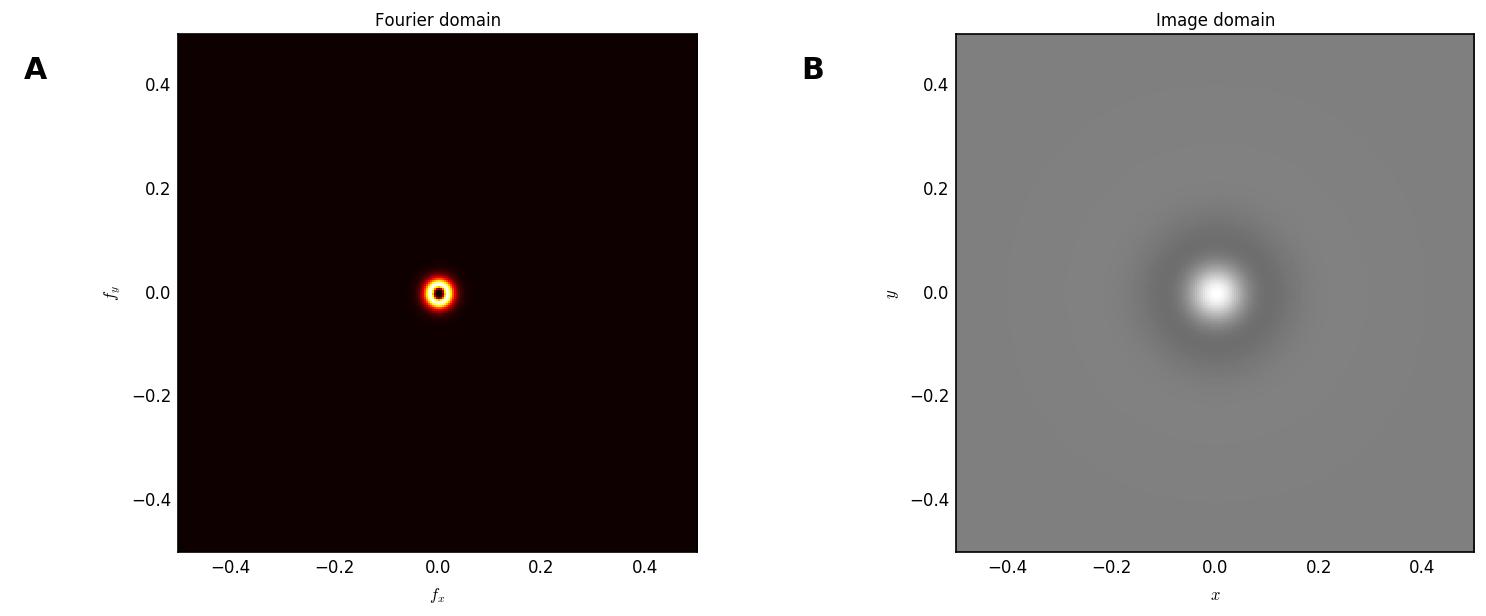

In [7]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': np.inf}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
(fourier_domain(mp.normalize(np.absolute(FT_lg), center=False))
+ image_domain(mp.normalize(mp.invert(FT_lg), center=False)))

When defining the framework, one thus needs only one angle:

In [ ]:
print ('Range of angles: ', mp.theta*180./np.pi)
mp.pe.n_theta = 1
mp.pe.B_theta = np.inf
mp.init()
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
Range of angles:  [ 90.]


In [ ]:
mp.pe.N = 1024

image = mp.imread('https://raw.githubusercontent.com/meduz/SparseEdges/master/database/lena256.png')

name = 'retina_sparseness_example'
image = mp.normalize(image, center=True)
matname = os.path.join(mp.pe.matpath, name + '.npy')
try:
    edges = np.load(matname)
except:
    edges, C_res = mp.run_mp(image, verbose=True)
    np.save(matname, edges)    


image_rec = mp.reconstruct(edges, mask=True)        

Edge 0 / 1024  - Max activity  :  3.06183934452  phase=  -5.17016657534e-14  deg,  @  (212, 88, 0, 3)
Edge 1 / 1024  - Max activity  :  2.93855901684  phase=  -180.0  deg,  @  (219, 89, 0, 2)
Edge 2 / 1024  - Max activity  :  2.7573443855  phase=  -8.09394733889e-15  deg,  @  (165, 74, 0, 3)
Edge 3 / 1024  - Max activity  :  2.712688706  phase=  180.0  deg,  @  (124, 68, 0, 3)
Edge 4 / 1024  - Max activity  :  2.99065641963  phase=  -2.8995659456e-14  deg,  @  (124, 68, 0, 2)
Edge 5 / 1024  - Max activity  :  2.70284617383  phase=  1.02315955274e-14  deg,  @  (134, 137, 0, 4)
Edge 6 / 1024  - Max activity  :  2.70180420102  phase=  -180.0  deg,  @  (212, 87, 0, 3)
Edge 7 / 1024  - Max activity  :  2.65227666243  phase=  -3.4644246604e-14  deg,  @  (88, 200, 0, 3)
Edge 8 / 1024  - Max activity  :  3.34713888991  phase=  -6.28919597354e-15  deg,  @  (85, 202, 0, 3)
Edge 9 / 1024  - Max activity  :  3.00033460037  phase=  9.53324053323e-15  deg,  @  (81, 203, 0, 3)
Edge 10 / 1024  - Max a

In [ ]:
mp.pe.line_width = 0
fig, a = mp.show_edges(edges, image=mp.dewhitening(image_rec), show_phase=False, mask=True)

## Running simulations on a set of natureal images

In [ ]:
%%writefile ../test/experiment_retina_sparseness.py
# -*- coding: utf8 -*-
from __future__ import division, print_function
"""

$ python experiment_retina_sparseness.py

rm -fr **/retina_sparseness* **/**/retina_sparseness*

"""
import numpy as np
from SparseEdges import SparseEdges

for name_database in ['serre07_distractors']:#, 'serre07_distractors_urban', 'laboratory']:
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.seed = 21341353 # this ensures that all image lists are the same for the different experiments
    mp.pe.N_image = 20
    mp.pe.N = 1024
    mp.pe.n_theta = 1
    mp.pe.B_theta = np.inf
    mp.init()

    # control experiment
    imageslist, edgeslist, RMSE = mp.process(exp='retina_sparseness', name_database=name_database)



In [ ]:
%run experiment_retina_sparseness.py

## Analysing results

First, we retrieve edges from a prior edge extraction

In [ ]:
imageslist, edgeslist, RMSE = mp.process(exp='retina_sparseness', name_database=name_database_)

In [ ]:
fig, A = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
#mod = PowerLawModel()
mod = ExpressionModel('rho**x')
RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
rho = np.zeros(RMSE.shape[0])
for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'rho':.99}
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=False)
    #print(out.fit_report(min_correl=0.25))
    rho[i_image] =  out.params.get('rho').value
    #print 'rho=', rho[i_image]
    #N_theta = np.log(threshold)/np.log(rho)
    #print N_theta
    A.semilogx( RMSE[i_image, :], alpha=.7)
    params = mod.make_params(rho=rho[i_image])
    A.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    A.set_xlabel('l0')
    A.axis('tight')
    A.axis('tight')
    _ = A.set_ylabel('RMSE')            

print ('rho=', rho.mean(), ', +/- ', rho.std())

In [ ]:
fig_width = 15
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=[mp], experiments=['retina_sparseness'], databases=[name_database_], fig=fig, labels=[''], 
                  color=[0., 0., 1.], scale=False)#  

In [ ]:
%cd ../notebooks

## some book keeping for the notebook

In [ ]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

In [ ]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy